In [3]:

import pandas as np
import numpy as np
import matplotlib.pyplot as plt
import ta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import alpaca_trade_api as tradeapi

#CONFIG


API_KEY="AKP4AOHG4L32CXUO1YW1"
API_KEY="AKP4AOHG4L32CXUO1YW1"
SECRET_KEY="EeJzdxfmCPjU0gFsV3CqcvgUJMep8Ft08Bg20LMs"
BASE_URL="https://paper-api.alpaca.markets"


In [36]:
#Getting Bitcoin data from Alpaca

def get_btc_data():
    start_date="2023-01-01"
    api=tradeapi.REST(API_KEY,SECRET_KEY,base_url=BASE_URL)
    bars=api.get_crypto_bars("BTC/USD",timeframe="1Day",start=start_date).df
    btc_df= bars[bars['symbol']=='BTC/USD']

#resampling to weekly 
    btc_weekly=btc_df.resample('1W').agg({
    'open':'first',
    'high':'max',
    'low':'min',
    'close':'last',
    'volume':'sum',
    'vwap':'mean',
    'trade_count':'sum',
    'symbol':'last'


}).dropna()
    return btc_weekly

btc=get_btc_data()
print(btc.head())



                               open      high       low     close  \
timestamp                                                           
2023-01-01 00:00:00+00:00  16525.00  16695.31  16495.06  16642.78   
2023-01-08 00:00:00+00:00  16644.37  17248.53  16600.00  17196.67   
2023-01-15 00:00:00+00:00  17198.94  21420.56  17126.73  21175.00   
2023-01-22 00:00:00+00:00  21175.01  23349.81  19800.00  22715.61   
2023-01-29 00:00:00+00:00  22719.69  23964.19  22299.00  23733.59   

                                 volume          vwap  trade_count   symbol  
timestamp                                                                    
2023-01-01 00:00:00+00:00   1651.559057  16578.560487        34627  BTC/USD  
2023-01-08 00:00:00+00:00  24257.648294  16852.862613       394566  BTC/USD  
2023-01-15 00:00:00+00:00  80248.426500  18885.738344      1086083  BTC/USD  
2023-01-22 00:00:00+00:00  43672.846515  21683.456530       940022  BTC/USD  
2023-01-29 00:00:00+00:00  36424.619671  23057.7

In [37]:
#Adding Technical Indicators RSI and MACD which are very used industry wise 
#If RSI is > 70, asset is overbought , if <30 Asset is oversold
#MACD shows trend and momentum by comparing two moving averages

def add_indicators(df):
   
    df['rsi']=ta.momentum.RSIIndicator(df['close']).rsi()
    df['macd']=ta.trend.MACD(df['close']).macd()
    bb=ta.volatility.BollingerBands(df['close'])
    df['bollinger_h']=bb.bollinger_hband()
    df['bollinger_l']=bb.bollinger_lband()
    #checking na values
    print(df[['rsi','macd','bollinger_h','bollinger_l']].isna().sum())
    #fill  in na values
    df=df.bfill().ffill()
    return df

btc=add_indicators(btc)
btc.head()

rsi            13
macd           25
bollinger_h    19
bollinger_l    19
dtype: int64


,open,high,low,close,volume,vwap,trade_count,symbol,rsi,macd,bollinger_h,bollinger_l
timestamp,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,16525.00,16695.31,16495.06,16642.78,1651.559057,16578.560487,34627,BTC/USD,77.545562,1995.077325,32116.992347,17165.315424
2023-01-08 00:00:00+00:00,16644.37,17248.53,16600.00,17196.67,24257.648294,16852.862613,394566,BTC/USD,77.545562,1995.077325,32116.992347,17165.315424
2023-01-15 00:00:00+00:00,17198.94,21420.56,17126.73,21175.00,80248.426500,18885.738344,1086083,BTC/USD,77.545562,1995.077325,32116.992347,17165.315424
2023-01-22 00:00:00+00:00,21175.01,23349.81,19800.00,22715.61,43672.846515,21683.456530,940022,BTC/USD,77.545562,1995.077325,32116.992347,17165.315424
2023-01-29 00:00:00+00:00,22719.69,23964.19,22299.00,23733.59,36424.619671,23057.784122,836836,BTC/USD,77.545562,1995.077325,32116.992347,17165.315424


In [39]:
#creating features and labels such as price change, close , the signal . Features were the columns we created in prior step

def create_features_and_labels(df):
    df['price_change']=df['close'].pct_change().shift(-1)
    df['signal']=df['price_change'].apply(lambda x: 1 if x> 0.002 else -1 if x<-0.002 else 0)
    features=['rsi','macd','bollinger_h','bollinger_l']
    X=df[features].dropna()
    y=df.loc[X.index,'signal']
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, shuffle=False)
    return X_train,X_test,y_train,y_test,df
X_train,X_test,y_train,y_test,btc=create_features_and_labels(btc)




In [44]:
#train SVM Model
def train_svm_model(X_train,y_train):
    pipe=Pipeline([
        ('scaler',StandardScaler()),
        ('svc',SVC())
    ])
    paramms={
        'svc__C':[0.1,1,10],
        'svc__gamma':['scale',0.1,0.1],
        'svc__kernel':['rbf']
    }
    grid=GridSearchCV(pipe, paramms,cv=3,scoring='accuracy',n_jobs=-1)
    grid.fit(X_train,y_train)
    print("Best params:",grid.best_params_)
    return grid.best_estimator_
model=train_svm_model(X_train,y_train)


Best params: {'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


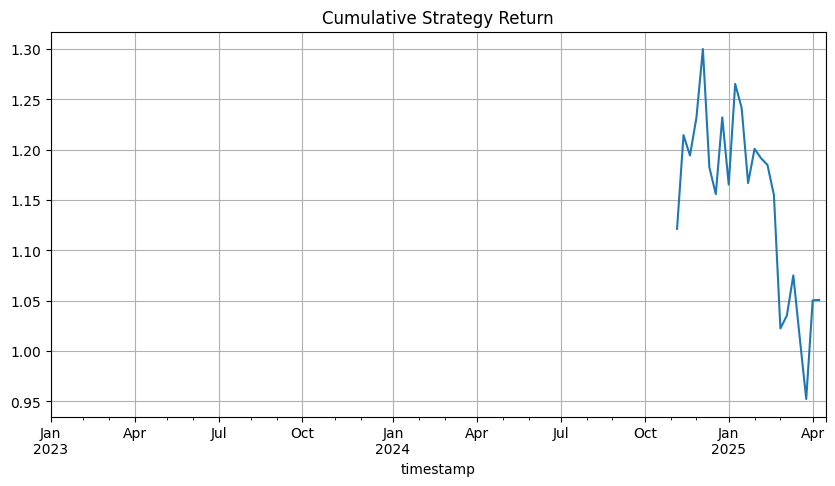

In [47]:
#Predict 

def predict_and_plot(model, X_test, y_test, df):
    df.loc[X_test.index, 'predicted_signal'] = model.predict(X_test)
    df['strategy_return'] = df['predicted_signal'].shift(1) * df['price_change']
    df['cumulative_return'] = (1 + df['strategy_return']).cumprod()
    df['cumulative_return'].plot(title='Cumulative Strategy Return', figsize=(10, 5))
    plt.grid(True)
    plt.show()

predict_and_plot(model, X_test, y_test, btc)

